In [42]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns

In [33]:
# Upload dataset
print("📂 Upload your CSV file:")
uploaded = files.upload()

filename = list(uploaded.keys())[0]
data = pd.read_csv(filename)
print(f"\nLoaded dataset '{filename}' with shape {data.shape}")
data.head()

📂 Upload your CSV file:


Saving hour.csv to hour (4).csv

Loaded dataset 'hour (4).csv' with shape (17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [34]:
# Inspect basic structure
data.info()
data.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


,0
instant,0
dteday,0
season,0
yr,0
mnth,0
hr,0
holiday,0
weekday,0
workingday,0
weathersit,0


In [35]:
data.duplicated().sum()


np.int64(0)

In [36]:
# Drop non-informative and leakage columns
# - instant: record index (no predictive meaning)
# - dteday: date string (information already encoded in other columns)
# - casual & registered: directly sum to target (cnt) → data leakage
data = data.drop(columns=['instant', 'dteday', 'casual', 'registered'])


In [37]:
# --- A. Cyclical Encoding (The "Clock Problem") ---
# Problem: The model thinks Hour 23 (11 PM) and Hour 0 (Midnight) are far apart (distance of 23).
#          In reality, they are right next to each other.
# Solution: Convert Hours into Sin/Cos coordinates to map them onto a circle.
data['hr_sin'] = np.sin(2 * np.pi * data['hr'] / 24)
data['hr_cos'] = np.cos(2 * np.pi * data['hr'] / 24)

# Do the same for Months (December is close to January)
data['mnth_sin'] = np.sin(2 * np.pi * data['mnth'] / 12)
data['mnth_cos'] = np.cos(2 * np.pi * data['mnth'] / 12)

# Remove the original 'hr' and 'mnth' columns so the model isn't confused by duplicate info
data = data.drop(['hr', 'mnth'], axis=1)

# --- B. One-Hot Encoding (The "Magnitude Problem") ---
# Problem: 'season' is 1,2,3,4. The model might wrongly think Season 4 > Season 1 mathematically.
# Solution: Convert to binary "Yes/No" columns (e.g., "Is_Winter", "Is_Spring").
# drop_first=True: Removes the first column to avoid redundancy (if it's not Spring, Summer, or Fall, it MUST be Winter).
data = pd.get_dummies(data, columns=['season', 'weathersit'],
                          prefix=['season', 'weather'], drop_first=True)

# --- C. Interaction Terms ---
# Problem: High Temp is usually good, but High Temp + High Humidity is bad.
# Solution: Multiply them to create a "Discomfort Index".
data['temp_hum_interaction'] = data['temp'] * data['hum']
data.head()

,yr,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,hr_sin,hr_cos,mnth_sin,mnth_cos,season_2,season_3,season_4,weather_2,weather_3,weather_4,temp_hum_interaction
0,0,0,6,0,0.24,0.2879,0.81,0.0,16,0.000000,1.000000,0.5,0.866025,False,False,False,False,False,False,0.1944
1,0,0,6,0,0.22,0.2727,0.80,0.0,40,0.258819,0.965926,0.5,0.866025,False,False,False,False,False,False,0.1760
2,0,0,6,0,0.22,0.2727,0.80,0.0,32,0.500000,0.866025,0.5,0.866025,False,False,False,False,False,False,0.1760
3,0,0,6,0,0.24,0.2879,0.75,0.0,13,0.707107,0.707107,0.5,0.866025,False,False,False,False,False,False,0.1800
4,0,0,6,0,0.24,0.2879,0.75,0.0,1,0.866025,0.500000,0.5,0.866025,False,False,False,False,False,False,0.1800


In [38]:
# Separate features (X) and target variable (y)
# - X: environmental and temporal features
# - y: total number of rented bikes (regression target)
X = data.drop(columns=['cnt'])
y = data['cnt']

In [39]:
# Split the data into training and testing sets
# - 80% training, 20% testing
# - random_state ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)
# Check shapes
print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)

Training set: (13903, 19) (13903,)
Testing set: (3476, 19) (3476,)


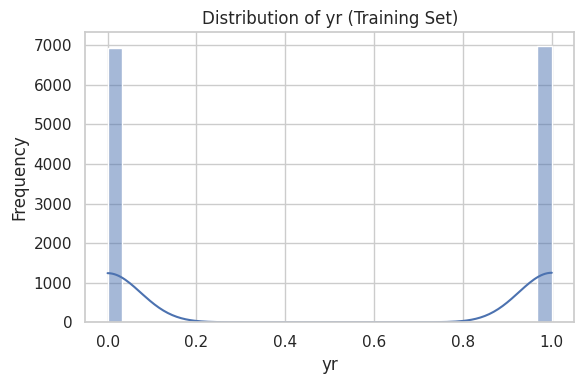

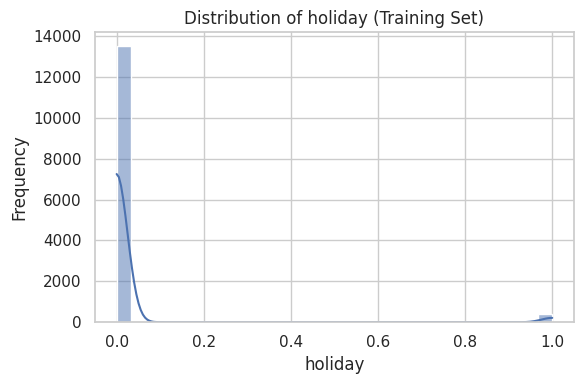

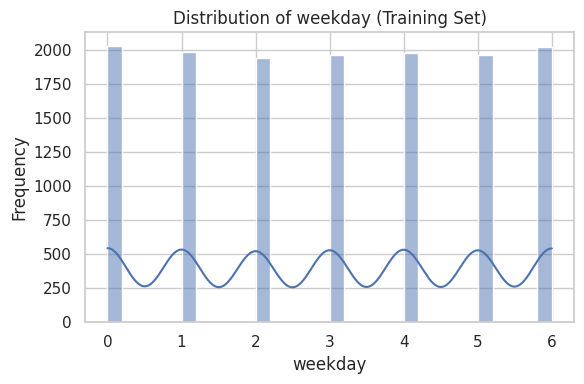

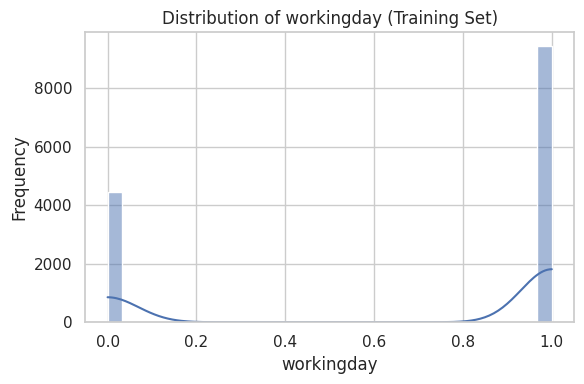

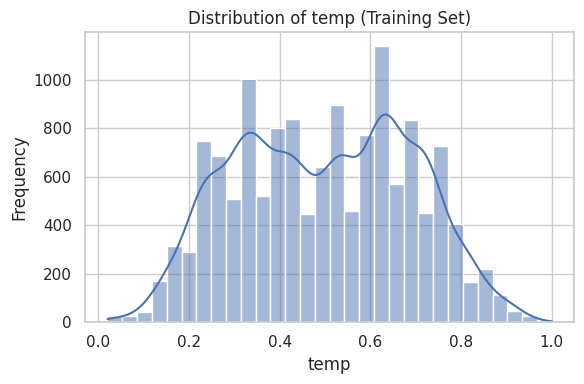

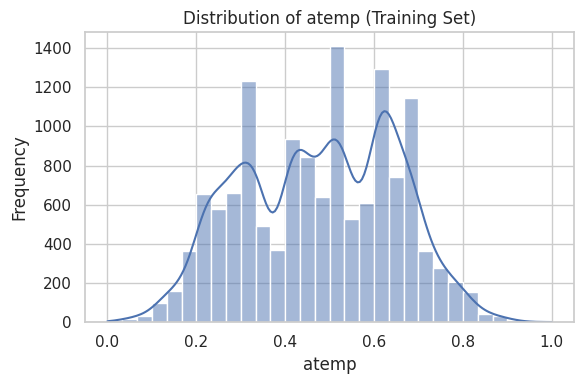

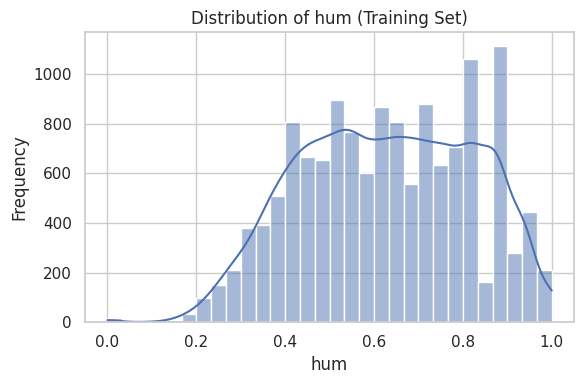

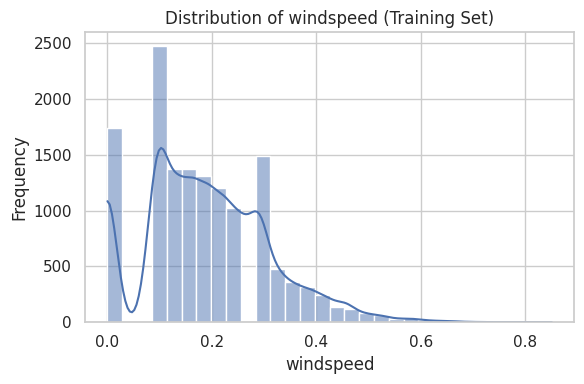

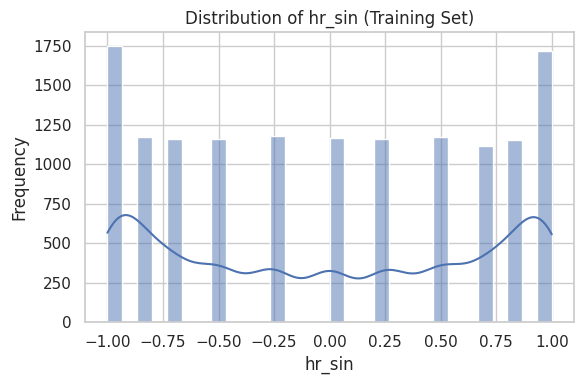

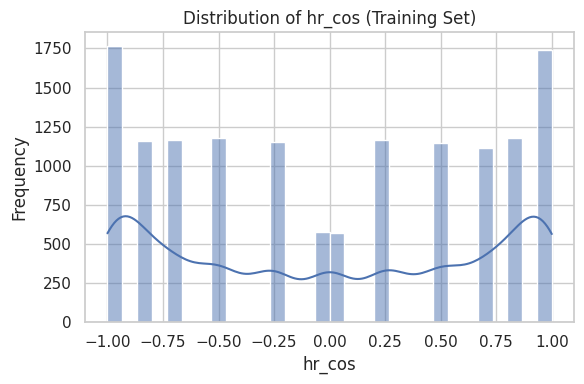

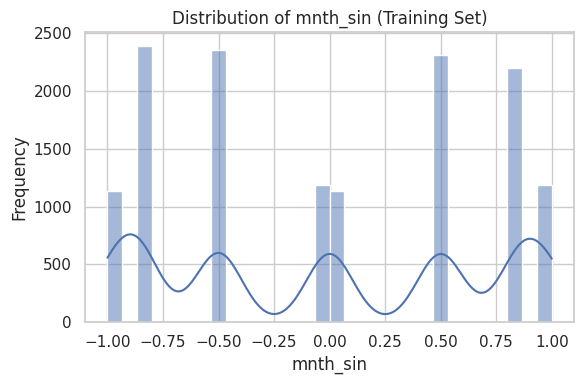

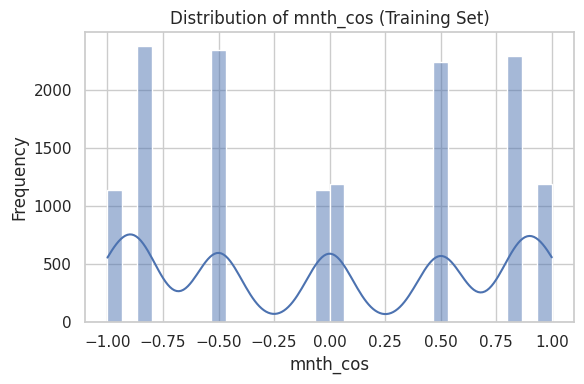

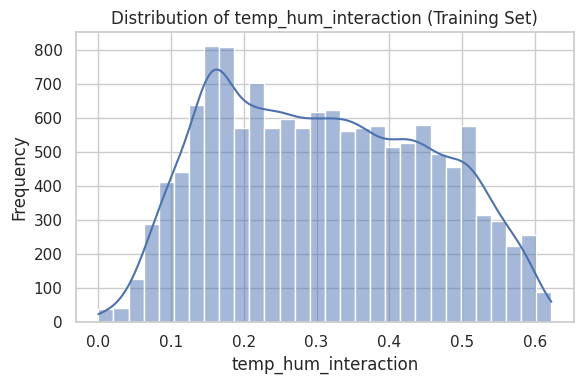

In [40]:
# Set visualization style
sns.set(style="whitegrid")

# Select numerical columns from training features
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Plot histograms for each numerical feature
for col in numerical_cols:
    plt.figure(figsize=(6, 4))

    # Plot histogram with KDE to observe distribution shape
    sns.histplot(X_train[col], bins=30, kde=True)

    # Add titles and labels
    plt.title(f"Distribution of {col} (Training Set)")
    plt.xlabel(col)
    plt.ylabel("Frequency")

    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()


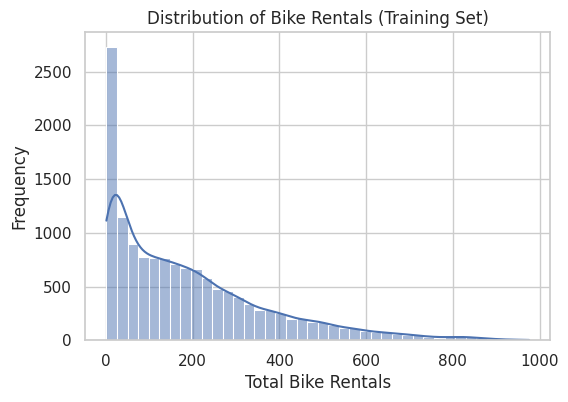

In [41]:
# Plot distribution of the target variable
plt.figure(figsize=(6, 4))

sns.histplot(y_train, bins=40, kde=True)

plt.title("Distribution of Bike Rentals (Training Set)")
plt.xlabel("Total Bike Rentals")
plt.ylabel("Frequency")

plt.show()


In [43]:
# KNN calculates "distance" between points. If one column is 0-1 (humidity)
# and another is 0-1000 (if unnormalized), KNN only cares about the large number.
# StandardScaler makes all columns compete fairly (mean=0, variance=1).
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
# --- Model 1: Linear Regression ---
# Good baseline. Checks if the relationship is simple (linear).
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

# --- Model 2: K-Nearest Neighbors (KNN) ---
# Looks for the 5 most similar past hours (e.g., "last Tuesday at 8am with similar temp").
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)

# --- Model 3: Random Forest ---
# Builds 100 decision trees. Can capture complex rules like:
# "If 8am AND weekday -> High Demand" BUT "If 8am AND Sunday -> Low Demand".
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train) # RF handles unscaled data fine, so we use raw X_train
y_pred_rf = rf_model.predict(X_test)

In [49]:
# print results
# save R^2 scores
r2_scores = {}
def print_metrics(model_name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    r2_scores[model_name] = r2
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"--- {model_name} ---")
    print(f"R^2 Score: {r2:.4f} (Closer to 1.0 is better)")
    print(f"MAE:       {mae:.2f} (Average error in bikes)")
    print(f"RMSE:      {rmse:.2f}\n")

print_metrics("Linear Regression", y_test, y_pred_lr)
print_metrics("K-Nearest Neighbors", y_test, y_pred_knn)
print_metrics("Random Forest", y_test, y_pred_rf)

--- Linear Regression ---
R^2 Score: 0.5105 (Closer to 1.0 is better)
MAE:       90.95 (Average error in bikes)
RMSE:      124.49

--- K-Nearest Neighbors ---
R^2 Score: 0.7939 (Closer to 1.0 is better)
MAE:       52.05 (Average error in bikes)
RMSE:      80.78

--- Random Forest ---
R^2 Score: 0.9428 (Closer to 1.0 is better)
MAE:       25.15 (Average error in bikes)
RMSE:      42.54



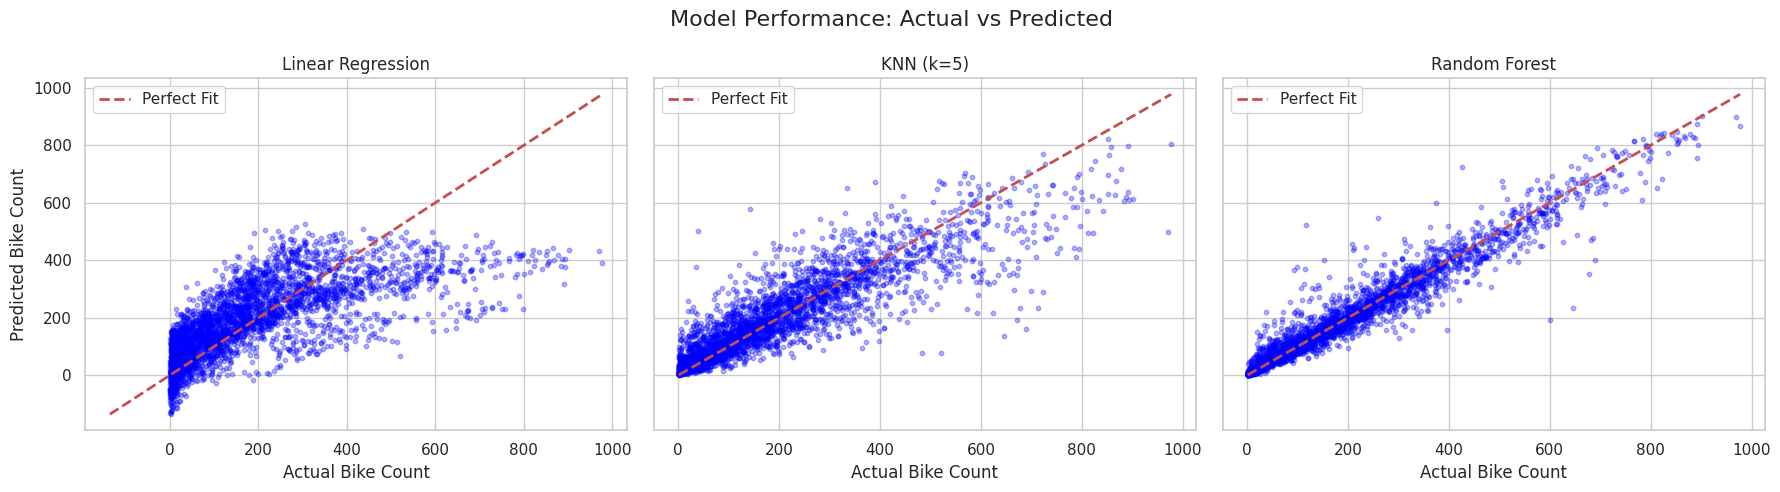

In [50]:
# Create a figure with subplots (1 row, 3 columns) for the scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# List of your models and their predictions
# (Make sure these variables exist from your training step)
model_data = [
    ("Linear Regression", y_pred_lr),
    ("KNN (k=5)", y_pred_knn),
    ("Random Forest", y_pred_rf)
]

# --- 1. Actual vs Predicted Scatter Plots ---
for i, (name, pred) in enumerate(model_data):
    # Scatter plot of Actual vs Predicted
    axes[i].scatter(y_test, pred, alpha=0.3, color='blue', s=10)

    # Draw the "Perfect Prediction" red dashed line
    min_val = min(y_test.min(), pred.min())
    max_val = max(y_test.max(), pred.max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')

    axes[i].set_title(f"{name}")
    axes[i].set_xlabel("Actual Bike Count")
    if i == 0: axes[i].set_ylabel("Predicted Bike Count")
    axes[i].legend()

plt.suptitle("Model Performance: Actual vs Predicted", fontsize=16)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1690528180.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')


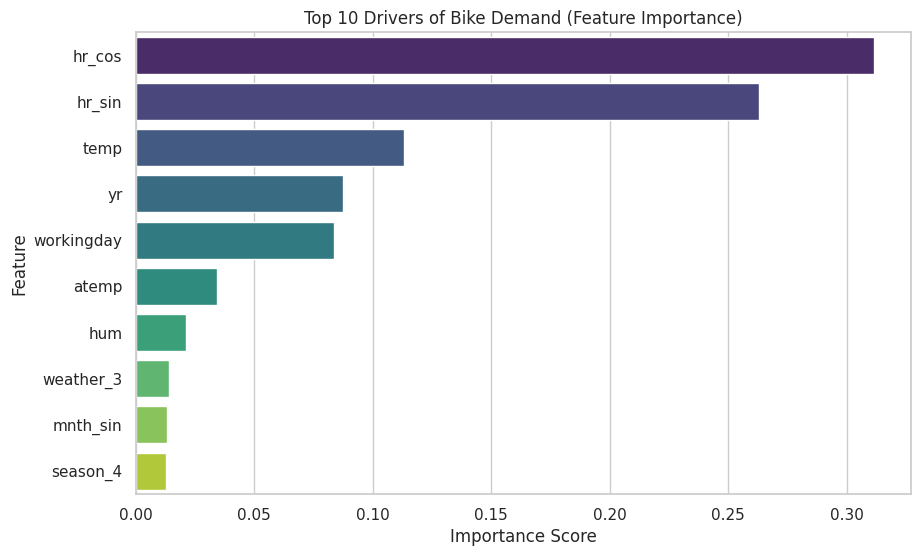

In [51]:
# Extract importances
importances = rf_model.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(10) # Top 10

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')
plt.title("Top 10 Drivers of Bike Demand (Feature Importance)")
plt.xlabel("Importance Score")
plt.show()

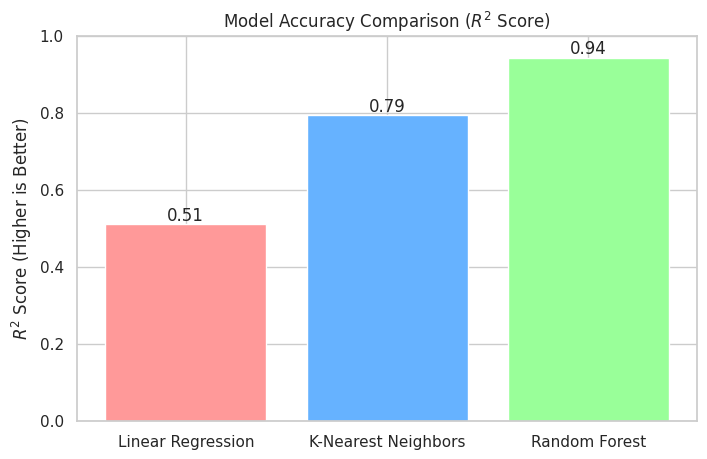

In [52]:
# Model Accuracy Comparison (Bar Chart) ---
plt.figure(figsize=(8, 5))
bars = plt.bar(r2_scores.keys(), r2_scores.values(), color=['#FF9999', '#66B2FF', '#99FF99'])
plt.title("Model Accuracy Comparison ($R^2$ Score)")
plt.ylabel("$R^2$ Score (Higher is Better)")
plt.ylim(0, 1)

# Add text labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom')
plt.show()